# Dense Associative Meomry

`DAM.py`にDense Associative Memoryを用いた分類器クラスを作成した．

本ノートブックでは，MNISTを用いて予測を行う．

## データセット

動作確認のため，とりあえずMNISTを引っ張ってくる．

In [7]:
import torch
import torchvision
import torchvision.transforms.v2 as v2

img_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float64, scale=True),
        v2.Lambda(lambda x: x.view(-1)),  # reshape to (784,1)
        v2.Lambda(lambda x: 2 * x - 1),  # rescale to [-1,1]
    ]
)

label_transform=v2.Compose(
    [
        v2.Lambda(lambda x:torch.tensor([float(i==x) for i in range(10)],dtype=torch.float64))
    ]
)

train_set = torchvision.datasets.MNIST(
    root="data",
    train=True,
    transform=img_transform,
    target_transform=label_transform,
    download=True,
)

test_set = torchvision.datasets.MNIST(
    root="data",
    train=False,
    transform=img_transform,
    target_transform=label_transform,
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
)

## $F(x)=x^2$の場合

### 分類器の訓練

In [8]:
from DAM import DAMClassifier


model1 = DAMClassifier(n_visible_unit=784, n_class_unit=10, n_memory_pattern=200, device=torch.device("cuda"))

model1.train(train_loader=train_loader,n_epoch=1,Temp=100)

100%|██████████| 1/1 [00:18<00:00, 18.96s/it]


### 分類器の予測

In [9]:
model1.predict_proba(test_set[0][0][None,:])

tensor([[0.1249, 0.0786, 0.0820, 0.0570, 0.0743, 0.1037, 0.0841, 0.1876, 0.1205,
         0.0872]], device='cuda:0', dtype=torch.float64,
       grad_fn=<PermuteBackward0>)

In [10]:
test_set[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)

### 重み行列の表示(1枚)

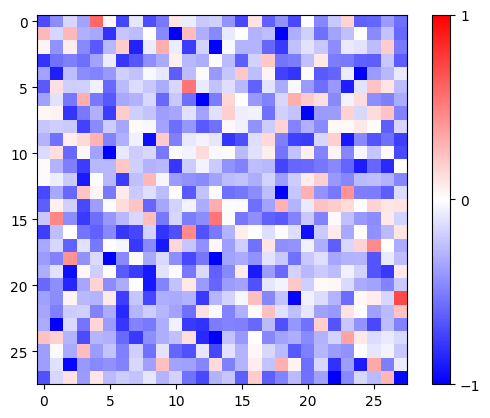

In [11]:
import numpy as np
import matplotlib.pyplot as plt

weight1 = model1.weight.numpy()

abs = np.max(np.abs(weight1[0]))

plt.imshow(weight1[0, :-10].reshape(28, 28), vmin=-abs, vmax=abs, cmap="bwr")
plt.colorbar(ticks=[-abs, 0, abs])

### 重み行列(10パターン分)

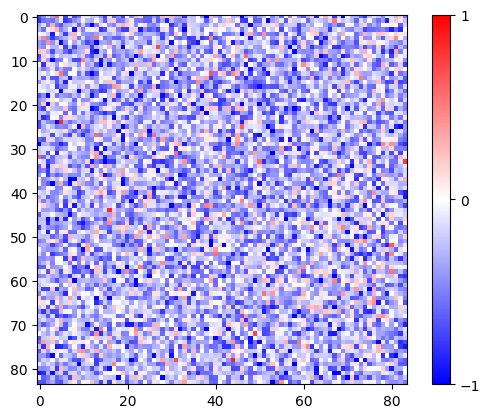

In [12]:
fig, axes = plt.subplots()

plt.imshow(
    weight1[:9, :-10].reshape(84, 84),
    vmin=-np.max(np.abs(weight1[:100, :-10])),
    vmax=np.max(np.abs(weight1[:100, :-10])),
    cmap="bwr"
)
plt.colorbar(ticks=[-np.max(np.abs(weight1[:100, :-10])), 0, np.max(np.abs(weight1[:100, :-10]))])

## $F(x)=x^{30}$の場合

loss_functionをMSEから

$$(y_{pred}-y_{true})^6$$
に変更する必要がある．


In [13]:
import torch.nn as nn


class MAELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()

    def forward(self, outputs, targets):

        loss = torch.mean(torch.abs(outputs - targets))
        return loss


class MeanNthPowerLoss(nn.Module):
    def __init__(self, degree: int = 2) -> None:
        super().__init__()
        self.degree = degree

    def forward(self, outputs, targets):
        loss = torch.mean(torch.abs(outputs - targets) ** self.degree)
        return loss

In [14]:
mae = MeanNthPowerLoss(degree=6)
mae(torch.ones(64, 10), torch.zeros(64, 10))

tensor(1.)

In [20]:
from functools import partial
from DAM import DAMClassifier

loss_function = partial(MeanNthPowerLoss, degree=6)

model2 = DAMClassifier(n_visible_unit=784, n_class_unit=10, n_memory_pattern=200, device=torch.device("cuda"))

model2.train(
    train_loader=train_loader,
    n_epoch=100,
    Temp=200**15,
    energy_function=lambda x: x**30,
    loss_function=loss_function,
)

100%|██████████| 100/100 [32:01<00:00, 19.21s/it]


### 分類器の予測

In [25]:
model2.predict_proba(test_set[0][0][None,:])

tensor([[9.0022e-21, 1.5425e-26, 7.9073e-18, 2.7117e-16, 4.7722e-10, 9.1446e-16,
         5.8220e-19, 1.0000e+00, 1.1875e-20, 1.5082e-08]], device='cuda:0',
       dtype=torch.float64, grad_fn=<PermuteBackward0>)

In [38]:
test_set[0][0][None,:].shape

torch.Size([1, 784])

In [26]:
test_set[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)

### accuracy

In [49]:
test_images = [test_set[i][0] for i, _ in enumerate(test_set)]
test_images = torch.concatenate(test_images)
test_images = test_images.reshape(-1, 784)


test_labels = [test_set[i][1] for i, _ in enumerate(test_set)]
test_labels = torch.concatenate(test_labels)
test_labels = test_labels.reshape(-1, 10).to("cuda")


acc = (torch.argmax(model2.predict_proba(test_images), dim=-1) == torch.argmax(test_labels, -1)).sum() / 1000

print(f"{acc=}")

acc=tensor(8.4820, device='cuda:0')


### 重み行列の表示(1枚)

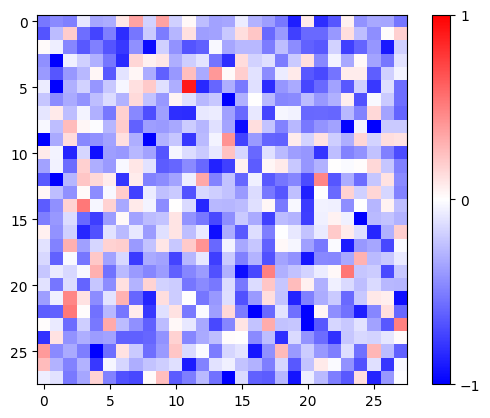

In [27]:
import numpy as np
import matplotlib.pyplot as plt

weight2 = model2.weight.numpy()

abs = np.max(np.abs(weight2[0]))

plt.imshow(weight2[0, :-10].reshape(28, 28), vmin=-abs, vmax=abs, cmap="bwr")
plt.colorbar(ticks=[-abs, 0, abs])

### 重み行列(9パターン分)

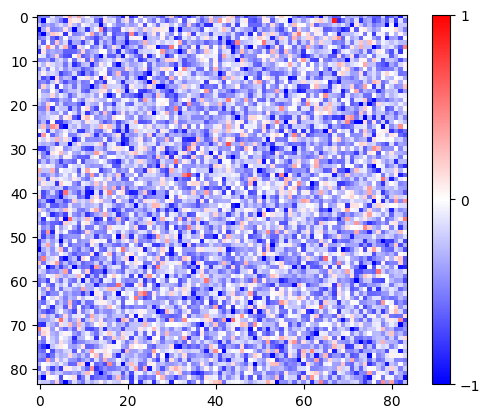

In [28]:
fig, axes = plt.subplots()

plt.imshow(
    weight2[:9, :-10].reshape(84, 84),
    vmin=-np.max(np.abs(weight2[:100, :-10])),
    vmax=np.max(np.abs(weight2[:100, :-10])),
    cmap="bwr"
)
plt.colorbar(ticks=[-np.max(np.abs(weight2[:100, :-10])), 0, np.max(np.abs(weight2[:100, :-10]))])